<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-09 17:10:48.785418: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 17:10:51.160790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-09 17:10:51.162036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-09 17:10:51.163180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-09 17:10:54,255[INFO][140371304535872-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

# generate datasets
train_size= 40 #@param {type:"integer"}
test_size = 2  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_source = '/cic/dataset/normalized_labeled/nsm-huongftp-label/' #@param {type:"string"}
L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()'])
predict_size = total_size // n_timesteps_in
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-02-09 17:10:56,925	WARNING read_api.py:256 -- The number of blocks in this dataset (3) limits its parallelism to 3 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 11.18it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_count

,label,count()
0,0.0,975
1,1.0,3266


## Data preview

### L_train preview

In [5]:
L_predict[[LABEL, *features]]

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999948,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999948,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999962,0.0,1.0,0.0,0.0,0.635149,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999999,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.995055,1.0,0.999329,0.0,0.995055,0.999329,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999381,0.0,1.0,0.0,0.0,0.664037,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999918,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999909,0.0,0.999329,0.999909,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.761594,0.0,0.129654,0.0,1.0,0.0,0.0,0.443188,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,0.383539,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.267171,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
4196,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.761594,0.0,0.131638,0.0,1.0,0.0,0.0,0.443188,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.0,1.0,0.388862,1.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.271102,0.0,1.0,1.0,0.0,1.0,

In [6]:
L_predict[[LABEL, *features]].describe()

,label,ack_flag_cnt,active_max,active_mean,active_min,active_std,bwd_blk_rate_avg,bwd_byts_b_avg,bwd_header_len,bwd_iat_max,bwd_iat_mean,bwd_iat_min,bwd_iat_std,bwd_iat_tot,bwd_pkt_len_max,bwd_pkt_len_mean,bwd_pkt_len_min,bwd_pkt_len_std,bwd_pkts_b_avg,bwd_pkts_s,bwd_psh_flags,bwd_seg_size_avg,bwd_urg_flags,cwe_flag_count,down_up_ratio,dst_port,ece_flag_cnt,fin_flag_cnt,flow_byts_s,flow_duration,flow_iat_max,flow_iat_mean,flow_iat_min,flow_iat_std,flow_pkts_s,fwd_act_data_pkts,fwd_blk_rate_avg,fwd_byts_b_avg,fwd_header_len,fwd_iat_max,fwd_iat_mean,fwd_iat_min,fwd_iat_std,fwd_iat_tot,fwd_pkt_len_max,fwd_pkt_len_mean,fwd_pkt_len_min,fwd_pkt_len_std,fwd_pkts_b_avg,fwd_pkts_s,fwd_psh_flags,fwd_seg_size_avg,fwd_seg_size_min,fwd_urg_flags,idle_max,idle_mean,idle_min,idle_std,init_bwd_win_byts,init_fwd_win_byts,pkt_len_max,pkt_len_mean,pkt_len_min,pkt_len_std,pkt_len_var,pkt_size_avg,protocol,psh_flag_cnt,rst_flag_cnt,src_port,subflow_bwd_byts,subflow_bwd_pkts,subflow_fwd_byts,subflow_fwd_pkts,syn_flag_cnt,tot_bwd_pkts,tot_fwd_pkts,totlen_bwd_pkts,totlen_fwd_pkts,urg_flag_cnt
count,4200.000000,4200.0,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.0,4200.000000,4200.0,4200.0,4200.000000,4200.0,4200.0,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.0,4200.000000,4200.000000,4200.0,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200.0,4200.0,4200.0,4200.000000,4200.000000,4200.0,4200.000000,4200.0,4200.0,4200.0,4200.000000,4200.000000,4200.000000,4200.000000,4200.0,4200.000000,4200.000000,4200.000000,4200.000000,4200.0
mean,0.768095,0.0,0.850000,0.850000,0.850000,0.850000,0.025714,0.025714,0.992857,0.978571,0.978571,0.973669,0.978571,0.978571,0.992857,0.992857,0.992857,0.867996,0.025710,0.348043,0.0,0.992857,0.0,0.0,0.564047,1.0,0.0,0.755973,0.993091,0.993095,0.988571,0.988095,0.954362,0.988571,0.641970,0.969849,0.012381,0.012381,0.999524,0.982143,0.982143,0.980690,0.982143,0.982143,0.999524,0.999524,0.999524,0.968413,0.012377,0.469098,0.0,0.999524,0.999524,0.0,0.907619,0.907619,0.907619,0.907619,0.971905,0.989762,1.0,1.0,1.0,0.990587,0.989863,1.0,0.999988,0.0,0.0,1.0,0.992857,0.990572,0.999524,0.996641,0.0,0.990572,0.996641,0.992857,0.999524,0.0
std,0.422099,0.0,0.357114,0.357114,0.357114,0.357114,0.158300,0.158300,0.084223,0.144825,0.144825,0.159748,0.144825,0.144825,0.084223,0.084223,0.084223,0.207756,0.158277,0.228673,0.0,0.084223,0.0,0.0,0.162489,0.0,0.0,0.065196,0.082817,0.082817,0.106305,0.110644,0.267437,0.106305,0.209207,0.154682,0.110592,0.110592,0.021819,0.132448,0.132448,0.137543,0.132448,0.132448,0.021819,0.021819,0.021819,0.151583,0.110555,0.225739,0.0,0.021819,0.021819,0.0,0.289597,0.289597,0.289597,0.289597,0.165265,0.100676,0.0,0.0,0.0,0.092181,0.097056,0.0,0.000001,0.0,0.0,0.0,0.084223,0.086894,0.021819,0.033108,0.0,0.086894,0.033108,0.084223,0.021819,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,1.0,0.999988,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0000

In [7]:
DataFrame.from_records(LX_predict[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999948,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999948,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999949,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999909,1.0,0.999909,0.0,0.999909,0.999909,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999962,0.0,1.0,0.0,0.0,0.635149,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999999,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.995055,1.0,0.999329,0.0,0.995055,0.999329,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.999381,0.0,1.0,0.0,0.0,0.664037,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.999918,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999909,0.0,0.999329,0.999909,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.964028,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.999696,0.0,1.0,0.0,0.0,0.833655,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,0.964028,1.0,1.000000,0.964028,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.998685,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999988,1.0,0.999909,0.0,0.999988,0.999909,1.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.369593,0.0,1.0,0.0,0.0,0.761594,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.650349,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.369593,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.999329,1.0,0.999329,0.0,0.999329,0.999329,1.0,1.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.000000,0.0,0.741177,0.0,1.0,0.0,0.0,0.462117,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.993452,0.761594,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.956763,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999988,0.0,0.0,1.0,1.0,0.761594,1.0,0.964028,0.0,0.761594,0.964028,1.0,1.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.315580,0.0,1.0,0.0,0.0,0.664037,1.0,0.0,0.761594,1.0,1.0,1.0,1.0,1.000000,1.0,0.626202,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.000000,0.387124,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,

In [8]:
DataFrame.from_records(LX_predict[0]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
count,100.0,100.00,100.00,100.00,100.00,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.000000,100.0,100.0,1.000000e+02,1.000000e+02,100.0,100.0,100.0,100.000000,100.0,100.000000,100.000000,100.00,100.00,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0,100.0,100.000000,100.000000,100.0,100.000000,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.0,100.0,100.0
mean,0.0,0.01,0.01,0.01,0.01,0.0,0.0,1.0,0.980000,0.980000,0.979633,0.980000,0.980000,1.0,1.0,1.0,0.928612,0.0,0.955550,0.0,1.0,0.0,0.0,0.694382,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,0.999633,1.0,0.976843,0.971274,0.01,0.01,1.0,0.980000,0.980000,0.980000,0.980000,0.980000,1.0,1.0,1.0,0.953240,0.009999,0.964531,0.0,1.0,1.0,0.0,0.020000,0.020000,0.020000,0.020000,0.980000,1.0,1.0,1.0,1.0,0.989232,0.984887,1.0,0.999988,0.0,0.0,1.0,1.0,0.995138,1.0,0.999246,0.0,0.995138,0.999246,1.0,1.0,0.0
std,0.0,0.10,0.10,0.10,0.10,0.0,0.0,0.0,0.140705,0.140705,0.140699,0.140705,0.140705,0.0,0.0,0.0,0.236888,0.0,0.155929,0.0,0.0,0.0,0.0,0.186585,0.0,0.0,2.231632e-16,1.519446e-08,0.0,0.0,0.0,0.003597,0.0,0.121522,0.143738,0.10,0.10,0.0,0.140705,0.140705,0.140705,0.140705,0.140705,0.0,0.0,0.0,0.196676,0.099991,0.150453,0.0,0.0,0.0,0.0,0.140705,0.140705,0.140705,0.140705,0.140705,0.0,0.0,0.0,0.0,0.075753,0.106327,0.0,0.000000,0.0,0.0,0.0,0.0,0.033535,0.0,0.005058,0.0,0.033535,0.005058,0.0,0.0,0.0
min,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.0,0.095655,0.0,1.0,0.0,0.0,0.462117,1.0,0.0,7.615942e-01,9.999999e-01,1.0,1.0,1.0,0.964028,1.0,0.199832,0.000000,0.00,0.00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.106207,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,0.461572,0.244268,1.0,0.999988,0.0,0.0,1.0,1.0,0.761594,1.0,0.964028,0.0,0.761594,0.964028,1.0,1.0,0.0
25%,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.975217,0.0,0.986132,0.0,1.0,0.0,0.0,0.526887,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,0.999997,1.000000,0.00,0.00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.999893,0.000000,0.987579,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
50%,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.999952,0.0,0.996118,0.0,1.0,0.0,0.0,0.602019,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,0.999997,1.000000,0.00,0.00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.999999,0.000000,0.998701,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
75%,0.0,0.00,0.00,0.00,0.00,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.0,0.999613,0.0,1.0,0.0,0.0,0.916903,1.0,0.0,7.615942e-01,1.000000e+00,1.0,1.0,1.0,1.000000,1.0,1.000000,1.000000,0.00,0.00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.000000,0.999660,0.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.999988,0.0,0.0,1.0,1.0,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,1.0,0.0
max,0.0,1.00,1.00,1.00,1.00,0.0,0.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,0.0,0.999990,0.0

In [9]:
DataFrame.from_records(Ly_predict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
38,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
39,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0

In [10]:
DataFrame.from_records(Ly_predict).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.714286,0.714286,0.785714,0.738095,0.738095,0.761905,0.785714,0.857143,0.761905,0.928571,0.809524,0.833333,0.880952,0.904762,0.857143,0.928571,0.857143,0.833333,0.857143,0.904762,0.738095,0.785714,0.857143,0.857143,0.785714,0.880952,0.880952,0.857143,0.880952,0.857143,0.880952,0.928571,0.809524,0.785714,0.857143,0.952381,0.880952,0.904762,0.880952,0.904762,0.833333,0.785714,0.738095,0.785714,0.833333,0.690476,0.761905,0.809524,0.761905,0.809524,0.904762,0.809524,0.809524,0.785714,0.785714,0.761905,0.761905,0.714286,0.809524,0.809524,0.761905,0.809524,0.785714,0.738095,0.761905,0.690476,0.690476,0.761905,0.761905,0.809524,0.642857,0.595238,0.714286,0.642857,0.738095,0.738095,0.761905,0.619048,0.595238,0.666667,0.619048,0.595238,0.547619,0.666667,0.642857,0.642857,0.571429,0.595238,0.714286,0.619048,0.714286,0.666667,0.714286,0.642857,0.666667,0.714286,0.738095,0.642857,0.690476,0.738095
std,0.457230,0.457230,0.415300,0.445001,0.445001,0.431081,0.415300,0.354169,0.431081,0.260661,0.397437,0.377195,0.327770,0.297102,0.354169,0.260661,0.354169,0.377195,0.354169,0.297102,0.445001,0.415300,0.354169,0.354169,0.415300,0.327770,0.327770,0.354169,0.327770,0.354169,0.327770,0.260661,0.397437,0.415300,0.354169,0.215540,0.327770,0.297102,0.327770,0.297102,0.377195,0.415300,0.445001,0.415300,0.377195,0.467901,0.431081,0.397437,0.431081,0.397437,0.297102,0.397437,0.397437,0.415300,0.415300,0.431081,0.431081,0.457230,0.397437,0.397437,0.431081,0.397437,0.415300,0.445001,0.431081,0.467901,0.467901,0.431081,0.431081,0.397437,0.484966,0.496796,0.457230,0.484966,0.445001,0.445001,0.431081,0.491507,0.496796,0.477119,0.491507,0.496796,0.503761,0.477119,0.484966,0.484966,0.500870,0.496796,0.457230,0.491507,0.457230,0.477119,0.457230,0.484966,0.477119,0.457230,0.445001,0.484966,0.467901,0.445001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

## Data visualization

In [11]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

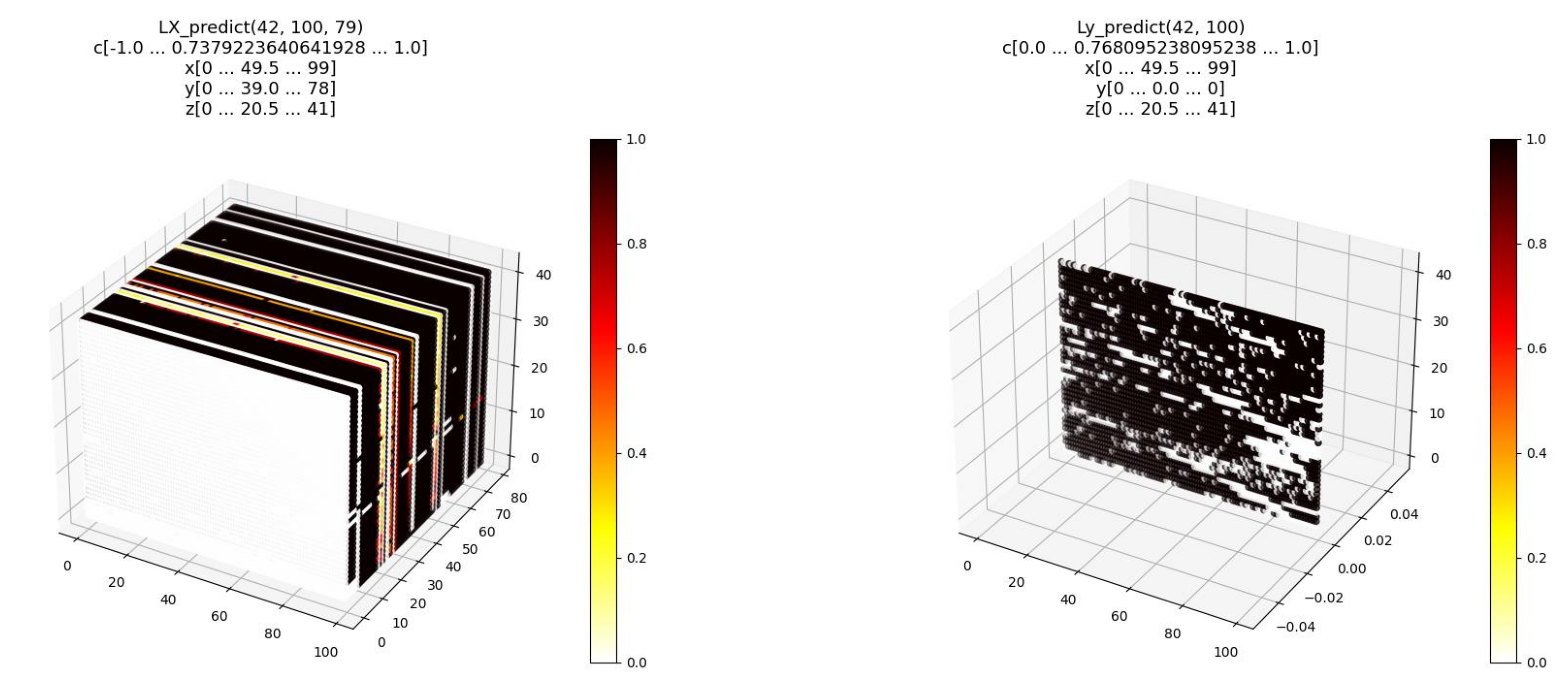

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [13]:
def threshold(num):
    return 1 if num > 0.5 else 0

def infer(name='model', checkpoint='anomaly_flow79_local_ftp_norm'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    print(f"predicted/Ly_predict = {predicted.sum()}/{Ly_predict.sum()}")
    #np.logical_and(predicted.reshape((56,100)), Ly_predict).sum()

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-02-09 17:11:17.034208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-09 17:11:17.035083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-09 17:11:17.035888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-09 17:11:17.036679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


predicted/Ly_predict = 3233/3226.0


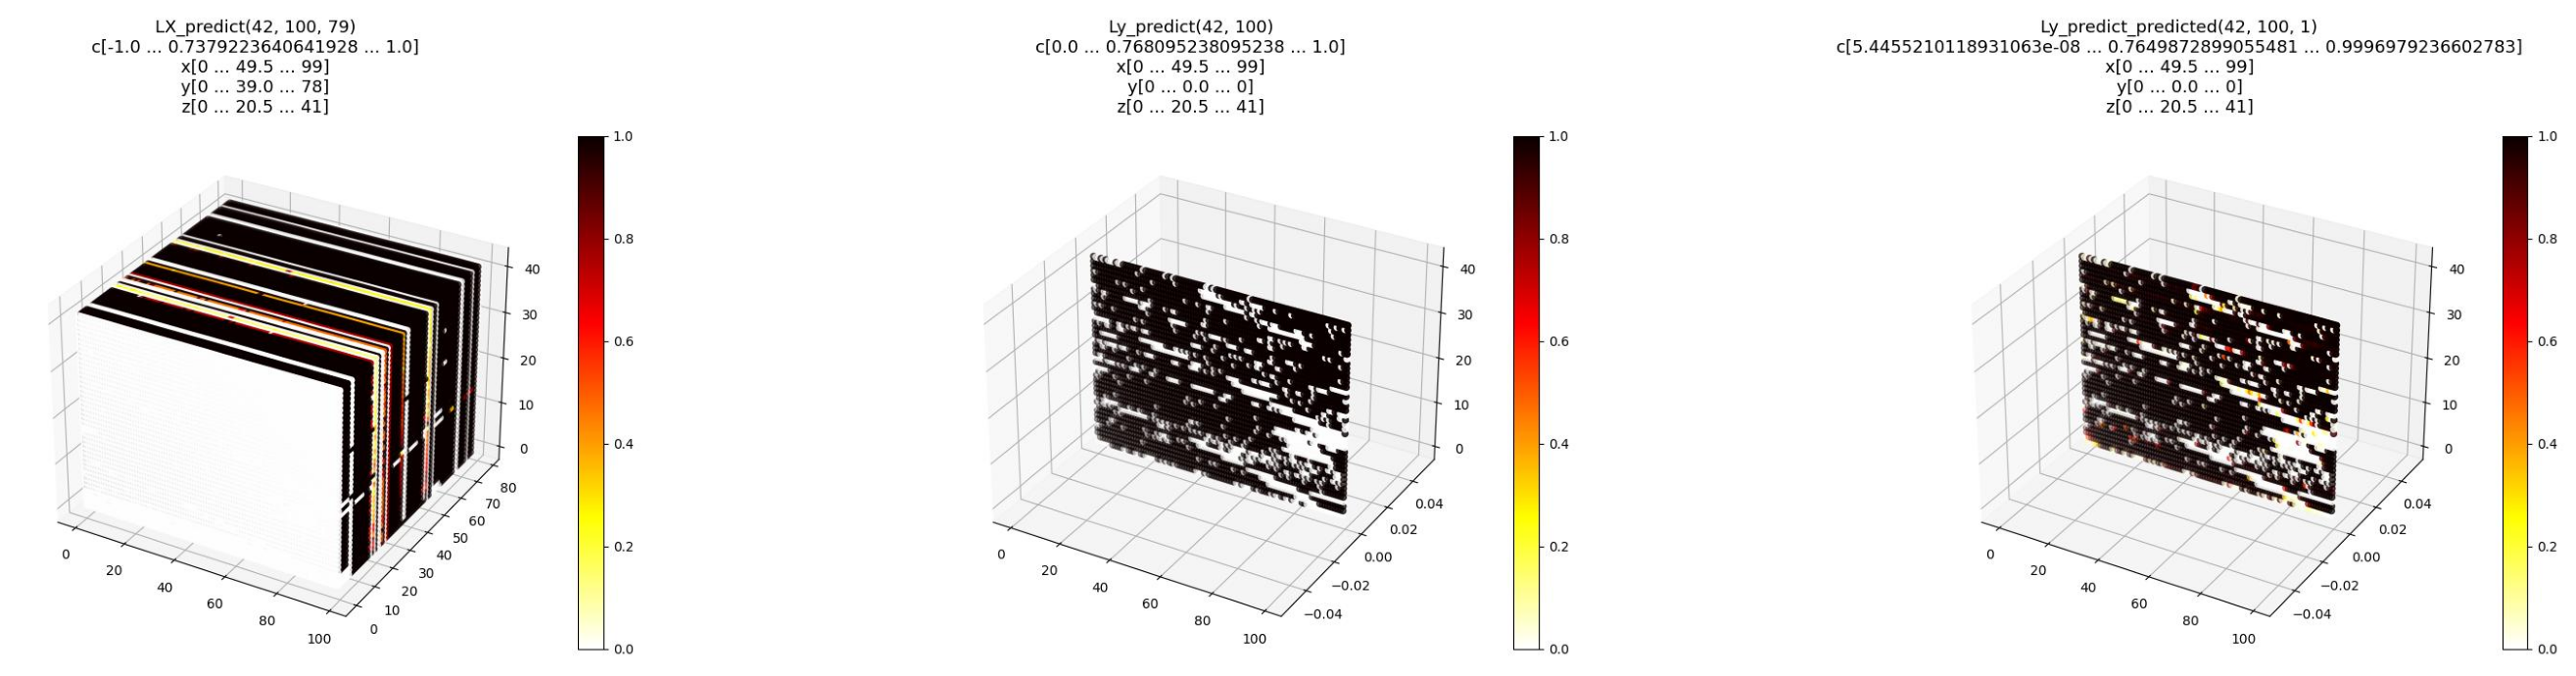

In [14]:
infer('model6', 'anomaly_flow79_local_ftp_norm')

predicted/Ly_predict = 33/3226.0


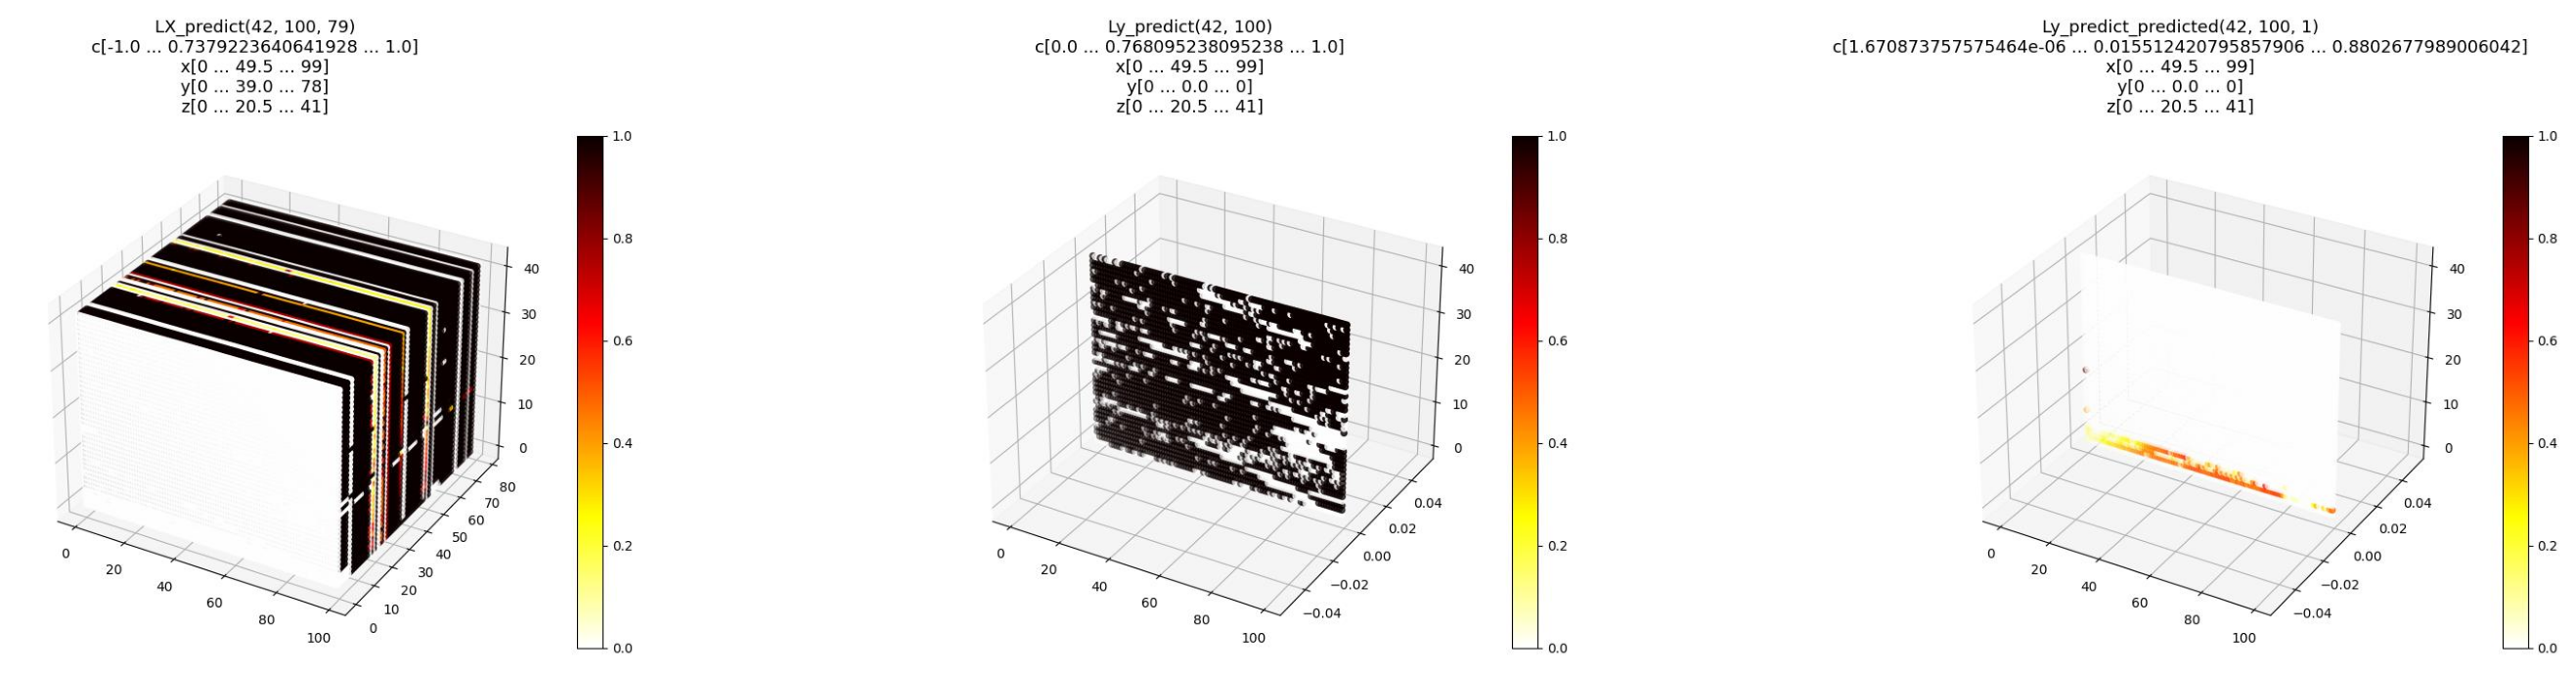

In [15]:
infer('model6', 'anomaly_flow79_local_ftp_transfer_local_ssh_norm')

In [ ]:
#infer('model6', 'anomaly_flow79_cic_ftp_norm')